In [83]:
import pandas as pd
import numpy as np
from quantulum3 import parser
import re
import matplotlib.pyplot as plt
from pyproj import Geod

# Read data
df = pd.read_csv('../data/raw/cost/powdery_mildew_fungicide_record_database.csv', encoding='utf-8')
df2 = pd.read_csv('../data/raw/data_2017_v2.csv', encoding='cp1252')
pesticide_price = pd.read_csv('../data/raw/cost/pesticide_price.csv', encoding='utf-8')

# Fix data entry errors
df['Product'] = df['Product'].str.replace('Gramoxone SL 2 ', 'Gramoxone SL 2')
df['Product'] = df['Product'].str.replace('Class Act ', 'Class Act')
df['Product'] = df['Product'].str.replace('InterLock', 'Interlock')

# Remove rows with missing values '.' in the Product column
df = df[df['Product'] != '.']

# Drop nan values from df in product column
df = df.dropna(subset=['Product'])

# Fix data entry error; mismatched June labels
df2['Month'] = df2['Month'].str.replace('June ', 'June')


# Unique Years
years = df['Year'].unique()

# Remove fields with missing values in Date column in either of the two datasets

for year in years:
    
    fields_to_delete = df2.loc[((df2['Date'] == '.') & (df2['Year'] == year)), 'Field ID'].tolist()
    
    if len(fields_to_delete) > 0:
    
        df2 = df2[~((df2['Field ID'].isin(fields_to_delete)) & (df2['Year'] == year))]
        df = df[~((df['Field ID'].isin(fields_to_delete)) & (df['Year'] == year))]
        
        
# Remove fields with missing values in Mildew Incidence column in either of the two datasets

for year in years:
    
    fields_to_delete = df2.loc[((df2['Mildew Incidence'] == '.') & (df2['Year'] == year)), 'Field ID'].tolist()
    
    if len(fields_to_delete) > 0:
    
        df2 = df2[~((df2['Field ID'].isin(fields_to_delete)) & (df2['Year'] == year))]
        df = df[~((df['Field ID'].isin(fields_to_delete)) & (df['Year'] == year))]
        
# Remove fields with Crystal variety in either of the two datasets

for year in years:
    
    fields_to_delete = df2.loc[((df2['Variety'] == 'Crystal') & (df2['Year'] == year)), 'Field ID'].tolist()
    
    if len(fields_to_delete) > 0:
    
        df2 = df2[~((df2['Field ID'].isin(fields_to_delete)) & (df2['Year'] == year))]
        df = df[~((df['Field ID'].isin(fields_to_delete)) & (df['Year'] == year))]


# MISSING VALUES

# Remove fields with missing values in Hill column in either of the two datasets

for year in years:
    
    fields_to_delete = df2.loc[((df2['Hill'] == '.') & (df2['Year'] == year)), 'Field ID'].tolist()
    
    if len(fields_to_delete) > 0:
    
        df2 = df2[~((df2['Field ID'].isin(fields_to_delete)) & (df2['Year'] == year))]
        df = df[~((df['Field ID'].isin(fields_to_delete)) & (df['Year'] == year))]

# Format date column
df['Spray Date'] = df['Spray Date'].astype('datetime64[ns]')
df['Spray Date'] = df['Spray Date'].dt.strftime('%m-%d-%Y')

df2['Date'] = df2['Date'].astype('datetime64[ns]')
df2['Date'] = df2['Date'].dt.strftime('%m-%d-%Y')

# Remove inconsistencies in Field IDs across datasets
for year in years:

    df_fields = df.loc[(df['Year'] == year), 'Field ID'].unique()
    df2_fields = df2.loc[(df2['Year'] == year), 'Field ID'].unique()

    fields_to_delete = np.setxor1d(df_fields, df2_fields)
    
    df2 = df2[~((df2['Field ID'].isin(fields_to_delete)) & (df2['Year'] == year))]
    df = df[~((df['Field ID'].isin(fields_to_delete)) & (df['Year'] == year))]

# Field IDs
field_ID = df[['Field ID', 'Year', 'Grower']]

# One hot encode the product column
dummies = pd.get_dummies(df['Product'])


# Extract numerical values from the 'Notes' column and convert gpa to oz per acre

for i in range(len(df['Notes'])):
    
    df['Notes'].iloc[i] = float(re.sub(r'[^\d.]', '', df['Notes'].iloc[i])) * 128
    
# Remove % from the 'Rate' column and multiply by oz per acre    
for i in range(len(df['Rate'])):
    
    if df['Rate'].iloc[i].endswith('%'):
        
        df['Rate'].iloc[i] = float((df['Rate'].iloc[i].replace('%', '')))
        df['Rate'].iloc[i] = (df['Rate'].iloc[i] / 100) * df['Notes'].iloc[i]

# Get list of unique products
product_list = df['Product'].unique()

# Remove any product which was deleted from database from the price data


products_to_delete = np.setxor1d(product_list, pesticide_price['Product'])

pesticide_price = pesticide_price[~(pesticide_price['Product'].isin(products_to_delete))]  

    
# Use code below to check for inconsistencies in Field IDs across datasets
#year = 2017

#df_fields = df.loc[(df['Year'] == year), 'Field ID'].unique()
#df2_fields = df2.loc[(df2['Year'] == year), 'Field ID'].unique()

#fields_to_delete = np.setxor1d(df_fields, df2_fields)
#print(fields_to_delete)

C:\Users\joshf\AppData\Local\Temp\ipykernel_9240\2314237246.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Notes'].iloc[i] = float(re.sub(r'[^\d.]', '', df['Notes'].iloc[i])) * 128
C:\Users\joshf\AppData\Local\Temp\ipykernel_9240\2314237246.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rate'].iloc[i] = float((df['Rate'].iloc[i].replace('%', '')))
C:\Users\joshf\AppData\Local\Temp\ipykernel_9240\2314237246.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

## Spray data and cost computation

In [84]:
# Wind columns
wind_columns = (df2.columns)[-32:].tolist()

# Lists to store data for mid-season
num_sprays = []
num_sprays_h = []
spray_data = []
spray_dummies_list = []
rate_list = []
field_list = []
year_list = []
grower_list = []
period_list = []
spray_rate_list = []
fungicide_cost_list = []
spray_date_list = []
spray_date_list_herb = []
spray_rate_list_herb = []
herbicide_cost_list = []
mildew_incidence_list = []
area_list = []
hill_list = []
w_pm_list = []
variety_list = []
sus_r6_list = []
sus_nonr6_list = []
initial_strain_list = []
wind_list = []
centroid_lat_list = []
centroid_long_list = []

# Early season
early_year_list = []
early_field_list = []
early_spray_data = []
early_num_sprays = []
early_num_sprays_h = []
early_spray_rate_list_herb = []
early_spray_rate_list = []
early_spray_dummies_list = []
early_spray_date_list = []
early_spray_date_list_herb = []
fungicide_early_cost_list = []
herbicide_early_cost_list = []

# Late season
late_year_list = []
late_field_list = []
late_grower_list = []
late_spray_data = []
late_num_sprays = []
late_num_sprays_h = []
late_spray_rate_list_herb = []
late_spray_rate_list = []
late_spray_dummies_list = []
late_spray_date_list = []
late_spray_date_list_herb = []
fungicide_late_cost_list = []
herbicide_late_cost_list = []
late_mildew_incidence_list = []



price = pesticide_price['Average R Price'].to_numpy()

for year in years:

    growers = df.loc[(df['Year'] == year), 'Grower'].unique()   

    for grower in growers:
        
        # Unique fields for a given year and grower
        unique_fields = df.loc[((df['Grower'] == grower) & (df['Year'] == year)), 'Field ID'].unique()

        for field in unique_fields:
            
            
            # Get unique dates in which fungicides were applied
            fungicide_dates = df.loc[((df['Type'] == 'Fungicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field)), 'Spray Date'].unique()
            
            # Get unique dates in which herbicides were applied
            herbicide_dates = df.loc[((df['Type'] == 'Herbicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field)), 'Spray Date'].unique()
            
            
            #...............................................................................................................
            # BEGIN EARLY SEASON COST CALCULATION
            early_year_list.append(year)
            early_field_list.append(field)
            # Select data for fungicide sprays within a given period
            mask = (fungicide_dates < df2[(df2['Field ID'] == field) & (df2['Year'] == year)].iloc[0, 2])
            spray_dates = fungicide_dates[mask]
            early_spray_date_list.append(spray_dates)
            
            # Select data for herbicide sprays within a given period
            mask_h = (herbicide_dates < df2[(df2['Field ID'] == field) & (df2['Year'] == year)].iloc[0, 2])
            herb_spray_dates = herbicide_dates[mask_h]
            early_spray_date_list_herb.append(herb_spray_dates)
            
            # Get index of rows in df that correspond to the spray dates where fungicides were applied
            mask_index = []
            mask_index1 = []
            mask_index_herb = []
            
            # Get index of rows in df that correspond to the spray dates where herbicides were applied
            mask_index_h = []
            mask_index1_h = []
            mask_index_herb_h = []
            
            
            # FUNGICIDES    
            for spray_date in spray_dates:
                
                mask_index_ = df.index[(df['Type'] != 'Herbicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)]
                mask_index_1 = df.index[(df['Type'] == 'Fungicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)][0]
                
                mask_index1.append(mask_index_1)
                
                # This is used to calculate herbicide cost with adjuvants
                mask_index_herb_ = df.index[(df['Type'] != 'Fungicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)]
                
                for i in range(len(mask_index_)):
                    
                    mask_index__ = mask_index_[i]
                    mask_index.append(mask_index__)
                    
                for i in range(len(mask_index_herb_)):
                    
                    mask_index_herb__ = mask_index_herb_[i]
                    mask_index_herb.append(mask_index_herb__)
            
            # HERBICIDES        
            for spray_date in herb_spray_dates:
                
                mask_index_h_ = df.index[(df['Type'] != 'Fungicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)]
                mask_index_1_h = df.index[(df['Type'] == 'Herbicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)][0]
                
                mask_index1_h.append(mask_index_1_h)
                
                for i in range(len(mask_index_h_)):
                    
                    mask_index___h = mask_index_h_[i]
                    mask_index_h.append(mask_index___h)
                    
            
            # Get products used for each spray in a given period
            spray_dummies = dummies.loc[mask_index].to_numpy()
            early_spray_dummies_list.append(spray_dummies)
            
            # This is used to calculate the number of fungicide sprays without double counting fungicides applied on same date
            spray_dummies_1 = dummies.loc[mask_index1].to_numpy()
            
            # This is used to calculate the number of herbicide sprays without double counting herbicides applied on same date
            spray_dummies_1_h = dummies.loc[mask_index1_h].to_numpy()
            
            # This is used to calculate herbicide cost with adjuvants
            spray_dummies_herb = dummies.loc[mask_index_herb].to_numpy()
            
            # Get number of fungicide sprays in a given period
            num_sprays_ = spray_dummies_1.sum()
            early_num_sprays.append(num_sprays_)
            
            # Get number of herbicide sprays in a given period
            num_sprays__h = spray_dummies_1_h.sum()
            early_num_sprays_h.append(num_sprays__h)
                

            # Get total amount of each product used for all sprays in a given period
            spray_data_ = np.sum(spray_dummies, axis=0)
            early_spray_data.append(spray_data_)
            
            
            # Spray Rates for Fungicides
            if len(mask_index) > 0 and num_sprays_ > 0:
                
                spray_rates = []
                
                for i in range(len(mask_index)):
                    
                    rates = (df['Rate'].loc[mask_index]).to_numpy()
                    
                    if type((df['Rate'].loc[mask_index].to_numpy())[i]) != float:
                        rate = float(re.sub(r'[^\d.]', '', (df['Rate'].loc[mask_index].to_numpy())[i]))
                    else:
                        rate = (df['Rate'].loc[mask_index].to_numpy())[i]
                    
                    spray_rate = rate * spray_dummies[i]
                    spray_rates.append(spray_rate)
                
                # Rates
                spray_rate_total = np.sum(spray_rates, axis=0)
                early_spray_rate_list.append(spray_rate_total)   
                    
                # Fungicide Cost    
                fungicide_cost = np.sum(spray_rate_total * price)
                fungicide_early_cost_list.append(fungicide_cost)
            
            # If no fungicides were applied in a given period
            else:
                
                # Rates
                spray_rate_total = np.zeros(dummies.shape[1], dtype=float)
                early_spray_rate_list.append(spray_rate_total)
                
                # Fungicide Cost
                fungicide_cost = 0.0
                fungicide_early_cost_list.append(fungicide_cost)
            
            # Spray Rates for Herbicides
            if len(mask_index_herb) > 0 and num_sprays__h > 0:
                
                spray_rates_herb = []
                
                for i in range(len(mask_index_herb)):
                    
                    rates_herb = (df['Rate'].loc[mask_index_herb]).to_numpy()
                    
                    if type((df['Rate'].loc[mask_index_herb].to_numpy())[i]) != float:
                        rate_herb = float(re.sub(r'[^\d.]', '', (df['Rate'].loc[mask_index_herb].to_numpy())[i]))
                    else:
                        rate_herb = (df['Rate'].loc[mask_index_herb].to_numpy())[i]
                    
                    spray_rate_herb = rate_herb * spray_dummies_herb[i]
                    spray_rates_herb.append(spray_rate_herb)
                
                # Rates
                spray_rate_total_herb = np.sum(spray_rates_herb, axis=0)
                early_spray_rate_list_herb.append(spray_rate_total_herb)   
                    
                # Herbicide Cost    
                herbicide_cost = np.sum(spray_rate_total_herb * price)
                herbicide_early_cost_list.append(herbicide_cost)
            
            # If no herbicides were applied in a given period
            else:
                
                # Herbicide Cost
                herbicide_cost = 0.0
                herbicide_early_cost_list.append(herbicide_cost)
            
            # END EARLY SEASON COST CALCULATION
            #...............................................................................................................
            
            #...............................................................................................................
            # BEGIN LATE SEASON COST CALCULATION
            late_year_list.append(year)
            late_field_list.append(field)
            late_grower_list.append(grower)
            
            # Select data for fungicide sprays within a given period
            mask = (fungicide_dates > df2[(df2['Field ID'] == field) & (df2['Year'] == year)].iloc[3, 2])
            spray_dates = fungicide_dates[mask]
            late_spray_date_list.append(spray_dates)
            
            # Select data for herbicide sprays within a given period
            mask_h = (herbicide_dates > df2[(df2['Field ID'] == field) & (df2['Year'] == year)].iloc[3, 2])
            herb_spray_dates = herbicide_dates[mask_h]
            late_spray_date_list_herb.append(herb_spray_dates)
            
            # Get index of rows in df that correspond to the spray dates where fungicides were applied
            mask_index = []
            mask_index1 = []
            mask_index_herb = []
            
            # Get index of rows in df that correspond to the spray dates where herbicides were applied
            mask_index_h = []
            mask_index1_h = []
            mask_index_herb_h = []
            
            
            # FUNGICIDES    
            for spray_date in spray_dates:
                
                mask_index_ = df.index[(df['Type'] != 'Herbicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)]
                mask_index_1 = df.index[(df['Type'] == 'Fungicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)][0]
                
                mask_index1.append(mask_index_1)
                
                # This is used to calculate herbicide cost with adjuvants
                mask_index_herb_ = df.index[(df['Type'] != 'Fungicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)]
                
                for i in range(len(mask_index_)):
                    
                    mask_index__ = mask_index_[i]
                    mask_index.append(mask_index__)
                    
                for i in range(len(mask_index_herb_)):
                    
                    mask_index_herb__ = mask_index_herb_[i]
                    mask_index_herb.append(mask_index_herb__)
            
            # HERBICIDES        
            for spray_date in herb_spray_dates:
                
                mask_index_h_ = df.index[(df['Type'] != 'Fungicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)]
                mask_index_1_h = df.index[(df['Type'] == 'Herbicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)][0]
                
                mask_index1_h.append(mask_index_1_h)
                
                for i in range(len(mask_index_h_)):
                    
                    mask_index___h = mask_index_h_[i]
                    mask_index_h.append(mask_index___h)
                    
            
            # Get products used for each spray in a given period
            spray_dummies = dummies.loc[mask_index].to_numpy()
            late_spray_dummies_list.append(spray_dummies)
            
            # This is used to calculate the number of fungicide sprays without double counting fungicides applied on same date
            spray_dummies_1 = dummies.loc[mask_index1].to_numpy()
            
            # This is used to calculate the number of herbicide sprays without double counting herbicides applied on same date
            spray_dummies_1_h = dummies.loc[mask_index1_h].to_numpy()
            
            # This is used to calculate herbicide cost with adjuvants
            spray_dummies_herb = dummies.loc[mask_index_herb].to_numpy()
            
            # Get number of fungicide sprays in a given period
            num_sprays_ = spray_dummies_1.sum()
            late_num_sprays.append(num_sprays_)
            
            # Get number of herbicide sprays in a given period
            num_sprays__h = spray_dummies_1_h.sum()
            late_num_sprays_h.append(num_sprays__h)
                

            # Get total amount of each product used for all sprays in a given period
            spray_data_ = np.sum(spray_dummies, axis=0)
            late_spray_data.append(spray_data_)
            
            
            # Spray Rates for Fungicides
            if len(mask_index) > 0 and num_sprays_ > 0:
                
                spray_rates = []
                
                for i in range(len(mask_index)):
                    
                    rates = (df['Rate'].loc[mask_index]).to_numpy()
                    
                    if type((df['Rate'].loc[mask_index].to_numpy())[i]) != float:
                        rate = float(re.sub(r'[^\d.]', '', (df['Rate'].loc[mask_index].to_numpy())[i]))
                    else:
                        rate = (df['Rate'].loc[mask_index].to_numpy())[i]
                    
                    spray_rate = rate * spray_dummies[i]
                    spray_rates.append(spray_rate)
                
                # Rates
                spray_rate_total = np.sum(spray_rates, axis=0)
                late_spray_rate_list.append(spray_rate_total)   
                    
                # Fungicide Cost    
                fungicide_cost = np.sum(spray_rate_total * price)
                fungicide_late_cost_list.append(fungicide_cost)
            
            # If no fungicides were applied in a given period
            else:
                
                # Rates
                spray_rate_total = np.zeros(dummies.shape[1], dtype=float)
                late_spray_rate_list.append(spray_rate_total)
                
                # Fungicide Cost
                fungicide_cost = 0.0
                fungicide_late_cost_list.append(fungicide_cost)
            
            # Spray Rates for Herbicides
            if len(mask_index_herb) > 0 and num_sprays__h > 0:
                
                spray_rates_herb = []
                
                for i in range(len(mask_index_herb)):
                    
                    rates_herb = (df['Rate'].loc[mask_index_herb]).to_numpy()
                    
                    if type((df['Rate'].loc[mask_index_herb].to_numpy())[i]) != float:
                        rate_herb = float(re.sub(r'[^\d.]', '', (df['Rate'].loc[mask_index_herb].to_numpy())[i]))
                    else:
                        rate_herb = (df['Rate'].loc[mask_index_herb].to_numpy())[i]
                    
                    spray_rate_herb = rate_herb * spray_dummies_herb[i]
                    spray_rates_herb.append(spray_rate_herb)
                
                # Rates
                spray_rate_total_herb = np.sum(spray_rates_herb, axis=0)
                late_spray_rate_list_herb.append(spray_rate_total_herb)   
                    
                # Herbicide Cost    
                herbicide_cost = np.sum(spray_rate_total_herb * price)
                herbicide_late_cost_list.append(herbicide_cost)
            
            # If no herbicides were applied in a given period
            else:
                
                # Herbicide Cost
                herbicide_cost = 0.0
                herbicide_late_cost_list.append(herbicide_cost)
            
            # END lATE SEASON COST CALCULATION
            #...............................................................................................................
            
            for t in range(4):
                #print([year, grower, field, t])
                field_list.append(field)
                grower_list.append(grower)
                year_list.append(year)
                
                # Mildew Incidence
                mildew_incidence = df2.loc[(df2['Year'] == year) & (df2['Grower'] == grower) & (df2['Field ID'] == field) , 'Mildew Incidence'].iloc[t]
                mildew_incidence = float(mildew_incidence)
                mildew_incidence_list.append(mildew_incidence)

                # Area
                area = df2.loc[(df2['Year'] == year) & (df2['Grower'] == grower) & (df2['Field ID'] == field), 'Area_Acres'].iloc[t]
                area = float(area)
                area_list.append(area)
                
                # Centroid Lat
                centroid_lat = df2.loc[(df2['Year'] == year) & (df2['Grower'] == grower) & (df2['Field ID'] == field), 'Centroid Lat'].iloc[t]
                centroid_lat = float(centroid_lat)
                centroid_lat_list.append(centroid_lat)
                
                # Centroid Long
                centroid_long = df2.loc[(df2['Year'] == year) & (df2['Grower'] == grower) & (df2['Field ID'] == field), 'Centroid Long'].iloc[t]
                centroid_long = float(centroid_long)
                centroid_long_list.append(centroid_long)
                
                # Hill (number of plants sampled)
                hill = df2.loc[(df2['Year'] == year) & (df2['Grower'] == grower) & (df2['Field ID'] == field) , 'Hill'].iloc[t]
                hill = int(hill)
                hill_list.append(hill)
                
                # w_pm (number of plants with powdery mildew)
                w_pm = df2.loc[(df2['Year'] == year) & (df2['Grower'] == grower) & (df2['Field ID'] == field) , 'w/PM'].iloc[t]
                w_pm = (w_pm)
                w_pm_list.append(w_pm)
                
                # Variety
                variety = df2.loc[(df2['Year'] == year) & (df2['Grower'] == grower) & (df2['Field ID'] == field) , 'Variety'].iloc[t]
                variety_list.append(variety)
                
                # Susceptibility to R6 Strains
                sus_r6 = df2.loc[(df2['Year'] == year) & (df2['Grower'] == grower) & (df2['Field ID'] == field) , 'Susceptibility to R6 Strains'].iloc[t]
                sus_r6 = int(sus_r6)
                sus_r6_list.append(sus_r6)
                
                # Susceptibility to non-R6 Strains
                sus_nonr6 = df2.loc[(df2['Year'] == year) & (df2['Grower'] == grower) & (df2['Field ID'] == field) , 'Susceptibility to non-R6 Strains'].iloc[t]
                sus_nonr6 = int(sus_nonr6)
                sus_nonr6_list.append(sus_nonr6)
                
                # Initial Strain
                initial_strain = df2.loc[(df2['Year'] == year) & (df2['Grower'] == grower) & (df2['Field ID'] == field) , 'Initial Strain'].iloc[t]
                initial_strain_list.append(initial_strain)
                
                # Wind
                wind_pre_list = []

                for i in wind_columns:
                    wind = df2.loc[(df2['Year'] == year) & (df2['Grower'] == grower) & (df2['Field ID'] == field), i].iloc[t]
                    wind = float(wind)
                    wind_pre_list.append(wind)

                wind_list.append(wind_pre_list)
                
                if t == 0:
                    
                    period = 'April'
                    period_list.append(period)
                    
                    # Get products used for each spray in a given period
                    spray_dummies = np.zeros(dummies.shape[1], dtype=int)
                    spray_dummies_list.append(spray_dummies)
                    
                    # Get number of fungicide sprays in a given period
                    num_sprays_ = 0
                    num_sprays.append(num_sprays_)
                    
                    # Get number of herbicide sprays in a given period
                    num_sprays__h = 0
                    num_sprays_h.append(num_sprays__h)

                    # Get total amount of each product used for all sprays in a given period
                    spray_data_ = np.zeros(dummies.shape[1], dtype=int)
                    spray_data.append(spray_data_)
                    
                    # Rates
                    spray_rate_total = np.zeros(dummies.shape[1], dtype=float)
                    spray_rate_list.append(spray_rate_total)
                    
                    # Fungicide Cost
                    fungicide_cost = 0.0
                    fungicide_cost_list.append(fungicide_cost)
                    
                    # Herbicide Cost
                    herbicide_cost = 0.0
                    herbicide_cost_list.append(herbicide_cost)
                
                    
                else:
                    
                    # Select data for fungicide sprays within a given period
                    mask = ((fungicide_dates >= df2[(df2['Field ID'] == field) & (df2['Year'] == year)].iloc[t-1, 2]) & (fungicide_dates < df2[(df2['Field ID'] == field) & (df2['Year'] == year)].iloc[t, 2]))
                    spray_dates = fungicide_dates[mask]
                    spray_date_list.append(spray_dates)
                    
                    # Select data for herbicide sprays within a given period
                    mask_h = ((herbicide_dates >= df2[(df2['Field ID'] == field) & (df2['Year'] == year)].iloc[t-1, 2]) & (herbicide_dates < df2[(df2['Field ID'] == field) & (df2['Year'] == year)].iloc[t, 2]))
                    herb_spray_dates = herbicide_dates[mask_h]
                    spray_date_list_herb.append(herb_spray_dates)
                    
                    # Get index of rows in df that correspond to the spray dates where fungicides were applied
                    mask_index = []
                    mask_index1 = []
                    mask_index_herb = []
                    
                    # Get index of rows in df that correspond to the spray dates where herbicides were applied
                    mask_index_h = []
                    mask_index1_h = []
                    mask_index_herb_h = []
                    
                    
                    # FUNGICIDES    
                    for spray_date in spray_dates:
                        
                        mask_index_ = df.index[(df['Type'] != 'Herbicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)]
                        mask_index_1 = df.index[(df['Type'] == 'Fungicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)][0]
                        
                        mask_index1.append(mask_index_1)
                        
                        # This is used to calculate herbicide cost with adjuvants
                        mask_index_herb_ = df.index[(df['Type'] != 'Fungicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)]
                        
                        for i in range(len(mask_index_)):
                            
                            mask_index__ = mask_index_[i]
                            mask_index.append(mask_index__)
                            
                        for i in range(len(mask_index_herb_)):
                            
                            mask_index_herb__ = mask_index_herb_[i]
                            mask_index_herb.append(mask_index_herb__)
                    
                    # HERBICIDES        
                    for spray_date in herb_spray_dates:
                        
                        mask_index_h_ = df.index[(df['Type'] != 'Fungicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)]
                        mask_index_1_h = df.index[(df['Type'] == 'Herbicide') & (df['Year'] == year) & (df['Grower'] == grower) & (df['Field ID'] == field) & (df['Spray Date'] == spray_date)][0]
                        
                        mask_index1_h.append(mask_index_1_h)
                        
                        for i in range(len(mask_index_h_)):
                            
                            mask_index___h = mask_index_h_[i]
                            mask_index_h.append(mask_index___h)
                          
                    
                    # Get products used for each spray in a given period
                    spray_dummies = dummies.loc[mask_index].to_numpy()
                    spray_dummies_list.append(spray_dummies)
                    
                    # This is used to calculate the number of fungicide sprays without double counting fungicides applied on same date
                    spray_dummies_1 = dummies.loc[mask_index1].to_numpy()
                    
                    # This is used to calculate the number of herbicide sprays without double counting herbicides applied on same date
                    spray_dummies_1_h = dummies.loc[mask_index1_h].to_numpy()
                    
                    # This is used to calculate herbicide cost with adjuvants
                    spray_dummies_herb = dummies.loc[mask_index_herb].to_numpy()
                    
                    # Get number of fungicide sprays in a given period
                    num_sprays_ = spray_dummies_1.sum()
                    num_sprays.append(num_sprays_)
                    
                    # Get number of herbicide sprays in a given period
                    num_sprays__h = spray_dummies_1_h.sum()
                    num_sprays_h.append(num_sprays__h)
                        

                    # Get total amount of each product used for all sprays in a given period
                    spray_data_ = np.sum(spray_dummies, axis=0)
                    spray_data.append(spray_data_)
                    
                    
                    # Spray Rates for Fungicides
                    if len(mask_index) > 0 and num_sprays_ > 0:
                        
                        spray_rates = []
                        
                        for i in range(len(mask_index)):
                            
                            rates = (df['Rate'].loc[mask_index]).to_numpy()
                            
                            if type((df['Rate'].loc[mask_index].to_numpy())[i]) != float:
                                rate = float(re.sub(r'[^\d.]', '', (df['Rate'].loc[mask_index].to_numpy())[i]))
                            else:
                                rate = (df['Rate'].loc[mask_index].to_numpy())[i]
                            
                            spray_rate = rate * spray_dummies[i]
                            spray_rates.append(spray_rate)
                        
                        # Rates
                        spray_rate_total = np.sum(spray_rates, axis=0)
                        spray_rate_list.append(spray_rate_total)   
                            
                        # Fungicide Cost    
                        fungicide_cost = np.sum(spray_rate_total * price)
                        fungicide_cost_list.append(fungicide_cost)
                    
                    # If no fungicides were applied in a given period
                    else:
                        
                        # Rates
                        spray_rate_total = np.zeros(dummies.shape[1], dtype=float)
                        spray_rate_list.append(spray_rate_total)
                        
                        # Fungicide Cost
                        fungicide_cost = 0.0
                        fungicide_cost_list.append(fungicide_cost)
                    
                    # Spray Rates for Herbicides
                    if len(mask_index_herb) > 0 and num_sprays__h > 0:
                        
                        spray_rates_herb = []
                        
                        for i in range(len(mask_index_herb)):
                            
                            rates_herb = (df['Rate'].loc[mask_index_herb]).to_numpy()
                            
                            if type((df['Rate'].loc[mask_index_herb].to_numpy())[i]) != float:
                                rate_herb = float(re.sub(r'[^\d.]', '', (df['Rate'].loc[mask_index_herb].to_numpy())[i]))
                            else:
                                rate_herb = (df['Rate'].loc[mask_index_herb].to_numpy())[i]
                            
                            spray_rate_herb = rate_herb * spray_dummies_herb[i]
                            spray_rates_herb.append(spray_rate_herb)
                        
                        # Rates
                        spray_rate_total_herb = np.sum(spray_rates_herb, axis=0)
                        spray_rate_list_herb.append(spray_rate_total_herb)   
                            
                        # Herbicide Cost    
                        herbicide_cost = np.sum(spray_rate_total_herb * price)
                        herbicide_cost_list.append(herbicide_cost)
                    
                    # If no herbicides were applied in a given period
                    else:
                        
                        # Herbicide Cost
                        herbicide_cost = 0.0
                        herbicide_cost_list.append(herbicide_cost)
                    
                if t == 1:
                    
                    period = 'May'
                    period_list.append(period)
                    
                elif t == 2:
                    
                    period = 'June'
                    period_list.append(period)
                    
                elif t == 3:
                    
                    period = 'July'
                    period_list.append(period)
            
# Convert lists to arrays
spray_data = np.array(spray_data)
spray_rate_array = np.array(spray_rate_list)

# Create dictionary of field IDs, year, grower, sprays, and cost

cost_data = {
    "Field ID" : field_list,
    "Year" : year_list,
    "Month" : period_list,
    "Centroid Lat" : centroid_lat_list,
    "Centroid Long" : centroid_long_list,
    "Grower" : grower_list,
    "Sprays" : num_sprays,
    "Herbicide Sprays" : num_sprays_h,
    "Fungicide Cost" : fungicide_cost_list,
    "Herbicide Cost" : herbicide_cost_list,
    "Area_Acres" : area_list,
    "Mildew Incidence" : mildew_incidence_list,
    "Hill" : hill_list,
    "w/PM" : w_pm_list,
    "Variety" : variety_list,
    "Susceptibility to R6 Strains" : sus_r6_list,
    "Susceptibility to non-R6 Strains" : sus_nonr6_list,
    "Initial Strain" : initial_strain_list
}

cost_data = pd.DataFrame(cost_data)


# Create dictionary for early season cost

early_cost_data = {
    "Field ID" : early_field_list,
    "Year" : early_year_list,
    "Sprays" : early_num_sprays,
    "Herbicide Sprays" : early_num_sprays_h,
    "Fungicide Cost" : fungicide_early_cost_list,
    "Herbicide Cost" : herbicide_early_cost_list
}

early_cost_data = pd.DataFrame(early_cost_data)

# Create dictionary for late season cost

late_cost_data = {
    "Field ID" : late_field_list,
    "Year" : late_year_list,
    "Sprays" : late_num_sprays,
    "Herbicide Sprays" : late_num_sprays_h,
    "Fungicide Cost" : fungicide_late_cost_list,
    "Herbicide Cost" : herbicide_late_cost_list
}

late_cost_data = pd.DataFrame(late_cost_data)

# Create an empty dictionary for wind data
wind_dict = {}

# Create a list of keys
keys = wind_columns

# Create a list of values
values = (np.array(wind_list).T).tolist()

# Create a for loop to add items to the dictionary
for i in range(len(keys)):
    # Add each key-value pair to the dictionary
    wind_dict[keys[i]] = values[i]

# Print the resulting dictionary
wind_dict = pd.DataFrame(wind_dict)

for i in wind_columns:

    cost_data[i] = wind_dict[i]
    
# Convert area from acres to hectares
cost_data['Area_Acres'] = cost_data['Area_Acres'].astype(float)
cost_data['Area_Acres'] = cost_data['Area_Acres'] * 0.404686
cost_data.rename(columns={'Area_Acres': 'Area_Hectares'}, inplace=True)

# Include application costs
fung_application_cost = 16.0 #need to adjust for inflation
herb_application_cost = 9.63 #need to adjust for inflation

# Convert application costs from dollars per acre to dollars per hectare
fung_application_cost = fung_application_cost * 2.471053814671653
herb_application_cost = herb_application_cost * 2.471053814671653

# PPI (Jan 2022 base) for 2014-2020
ppi = [89.63222295, 78.91586143, 71.31375327, 73.47443209, 73.05062119, 73.34955924, 71.70729197, 89.92332807, 107.9811162]
ppi_2020 = ppi[6]
ppi_2022 = ppi[8]

# Adjust application cost for inflation
fung_application_cost = fung_application_cost / ppi_2022 * 100
herb_application_cost = herb_application_cost / ppi_2020 * 100

# Convert cost from dollars per acre to dollars per hectare
cost_data['Fungicide Cost'] = cost_data['Fungicide Cost'] * 2.471053814671653
cost_data['Herbicide Cost'] = cost_data['Herbicide Cost'] * 2.471053814671653

early_cost_data['Fungicide Cost'] = early_cost_data['Fungicide Cost'] * 2.471053814671653
early_cost_data['Herbicide Cost'] = early_cost_data['Herbicide Cost'] * 2.471053814671653

late_cost_data['Fungicide Cost'] = late_cost_data['Fungicide Cost'] * 2.471053814671653
late_cost_data['Herbicide Cost'] = late_cost_data['Herbicide Cost'] * 2.471053814671653

# Include application costs in herbicide cost (no application cost included for fungicides in mid-season)
herb_cost_arr = cost_data['Herbicide Cost'].values + (herb_application_cost * cost_data['Herbicide Sprays']).values
cost_data['Herbicide Cost'] = herb_cost_arr

# Include application costs for fungicides and herbicides for early and late season only (no application cost included for fungicides in late-season)
late_herb_cost_arr = late_cost_data['Herbicide Cost'].values + (herb_application_cost * late_cost_data['Herbicide Sprays']).values
late_cost_data['Herbicide Cost'] = late_herb_cost_arr

early_herb_cost_arr = early_cost_data['Herbicide Cost'].values + (herb_application_cost * early_cost_data['Herbicide Sprays']).values
early_cost_data['Herbicide Cost'] = early_herb_cost_arr

early_fung_cost_arr = early_cost_data['Fungicide Cost'].values + (fung_application_cost * early_cost_data['Sprays']).values
early_cost_data['Fungicide Cost'] = early_fung_cost_arr

# Assign data types
cost_data.iloc[:, -32:] = cost_data.iloc[:, -32:].astype(float)
cost_data['Month'] = cost_data['Month'].astype('string')
cost_data['Grower'] = cost_data['Grower'].astype('string')
#cost_data['Initial Strain'] = cost_data['Initial Strain'].astype('string')
cost_data['Variety'] = cost_data['Variety'].astype('string')
cost_data['Mildew Incidence'] = cost_data['Mildew Incidence'].astype(float)
cost_data['w/PM'] = cost_data['w/PM'].astype(float)
cost_data['Sprays'] = cost_data['Sprays'].astype(float)
cost_data['Hill'] = cost_data['Hill'].astype(float)
cost_data['Centroid Lat'] = cost_data['Centroid Lat'].astype(float)
cost_data['Centroid Long'] = cost_data['Centroid Long'].astype(float)

early_cost_data['Sprays'] = early_cost_data['Sprays'].astype(float)
late_cost_data['Sprays'] = late_cost_data['Sprays'].astype(float)


# DATA CLEANING

# Fix data entry error; misclassified UNKNOWN as '.'
cost_data.loc[((cost_data['Initial Strain'] == '.') & (cost_data['w/PM'] > 0)), 'Initial Strain'] = 'UNKNOWN'

# Convert values of '.' or 'non-R6' in initial strain column to 0
cost_data.loc[(cost_data['Initial Strain'] == '.') | (cost_data['Initial Strain'] == 'non-R6'), 'Initial Strain'] = 0

# Convert values of ''UNKNOWN' or 'R6' in initial strain column to 1
cost_data.loc[(cost_data['Initial Strain'] == 'UNKNOWN') | (cost_data['Initial Strain'] == 'R6'), 'Initial Strain'] = 1

# Convert values of 'Susceptibility to R6/non-R6 Strains' to 1 if > 0
cost_data['Susceptibility to R6 Strains'] = (cost_data['Susceptibility to R6 Strains'] > 0).astype(int)
cost_data['Susceptibility to non-R6 Strains'] = (cost_data['Susceptibility to non-R6 Strains'] > 0).astype(int)

# Convert Initial Strain column to integer
cost_data['Initial Strain'] = cost_data['Initial Strain'].astype(int)

# Ensure Initial Strains for each field are consistent
for year in years:
    
    # Unique fields for a given year
    unique_fields = cost_data.loc[(cost_data['Year'] == year), 'Field ID'].unique()

    for field in unique_fields:
        
        # Check if all values in initial strain column are the same for a given field
        if len(cost_data.loc[((cost_data['Year'] == year) & (cost_data['Field ID'] == field)), 'Initial Strain'].unique()) > 1:
            
            # Get the initial strain value for the first spray in a given field
            initial_strain = cost_data.loc[((cost_data['Year'] == year) & (cost_data['Field ID'] == field)), 'Initial Strain'].iloc[0]
            
            # Assign the initial strain value to all sprays in a given field
            cost_data.loc[((cost_data['Year'] == year) & (cost_data['Field ID'] == field)), 'Initial Strain'] = initial_strain

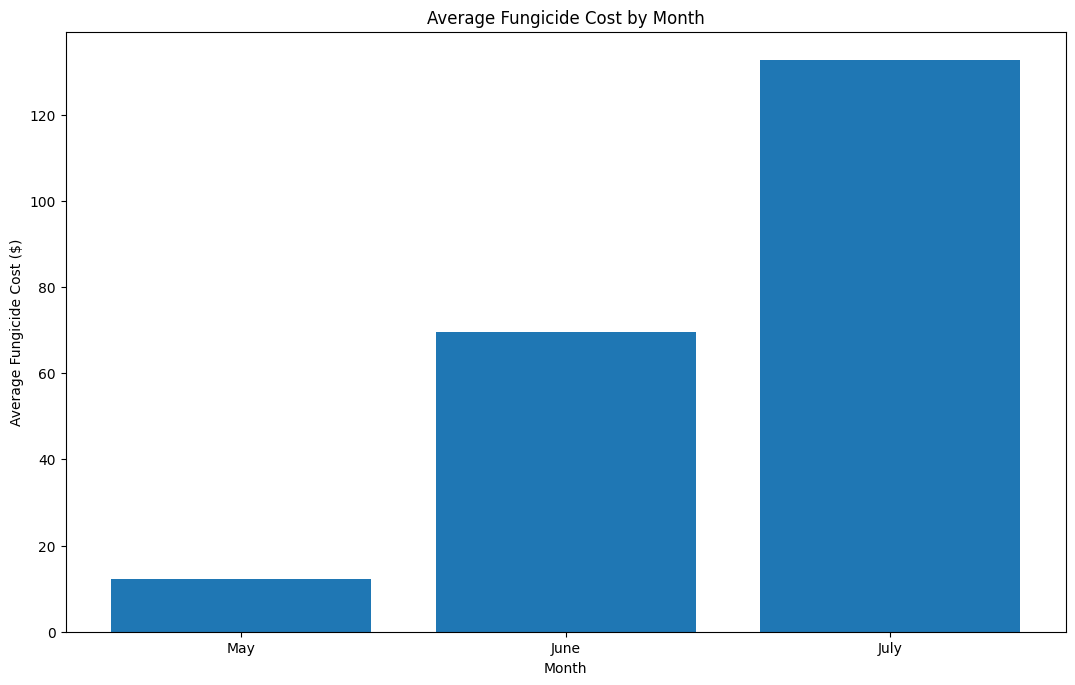

In [85]:
# Plot bar chart showing average fungicide cost by month with axis labels
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
month = ['May', 'June', 'July']
cost = [cost_data['Fungicide Cost'].loc[cost_data['Month'] == 'May'].mean(), 
        cost_data['Fungicide Cost'].loc[cost_data['Month'] == 'June'].mean(), 
        cost_data['Fungicide Cost'].loc[cost_data['Month'] == 'July'].mean()]
ax.bar(month,cost)
plt.xlabel('Month')
plt.ylabel('Average Fungicide Cost ($)')
plt.title('Average Fungicide Cost by Month')
plt.show()

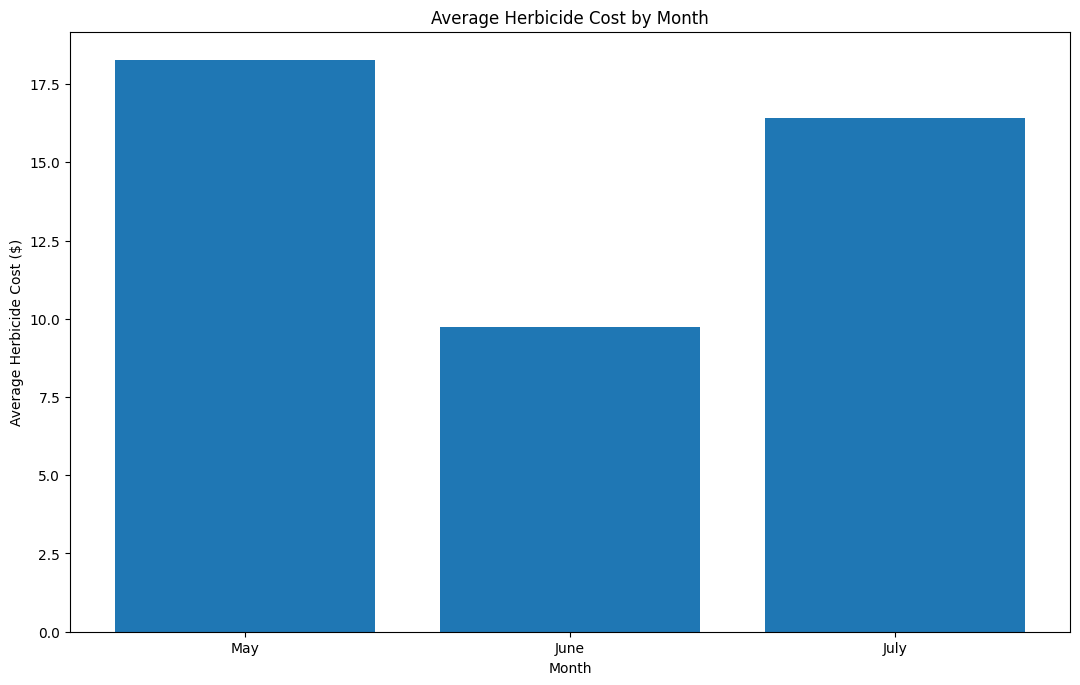

In [86]:
# Plot bar chart showing average herbicide cost by month with axis labels
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
month = ['May', 'June', 'July']
cost = [cost_data['Herbicide Cost'].loc[cost_data['Month'] == 'May'].mean(), 
        cost_data['Herbicide Cost'].loc[cost_data['Month'] == 'June'].mean(), 
        cost_data['Herbicide Cost'].loc[cost_data['Month'] == 'July'].mean()]
ax.bar(month,cost)
plt.xlabel('Month')
plt.ylabel('Average Herbicide Cost ($)')
plt.title('Average Herbicide Cost by Month')
plt.show()

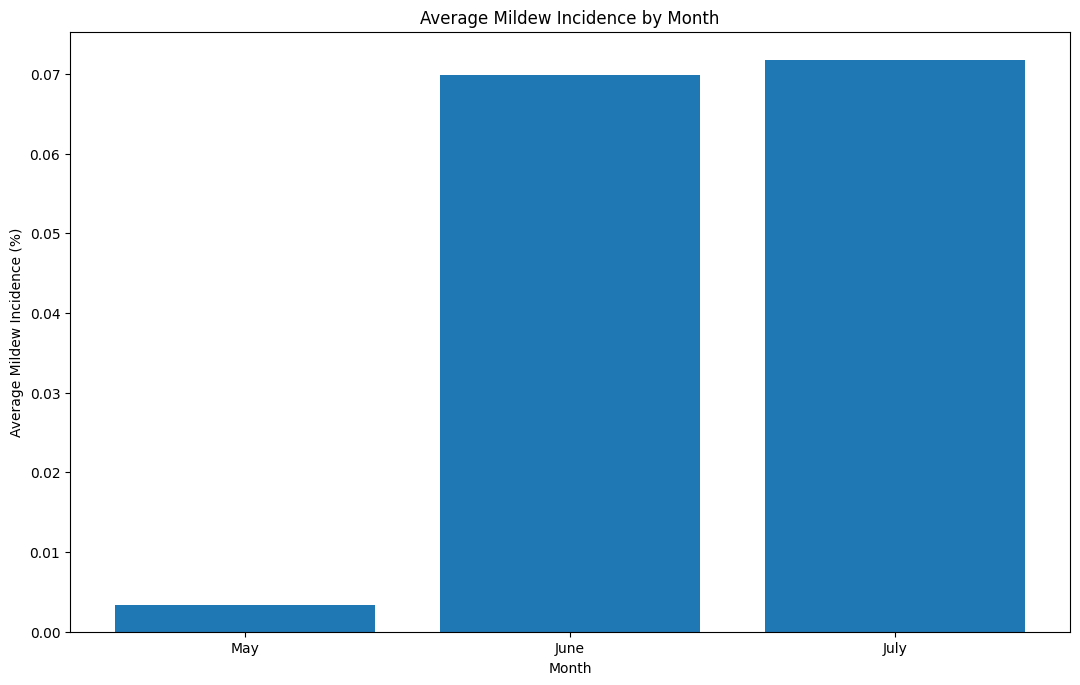

In [87]:
# Plot bar chart showing average mildew incidence by month with axis labels
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
month = ['May', 'June', 'July']
incidence = [cost_data['Mildew Incidence'].loc[cost_data['Month'] == 'May'].mean(),
                cost_data['Mildew Incidence'].loc[cost_data['Month'] == 'June'].mean(),
                cost_data['Mildew Incidence'].loc[cost_data['Month'] == 'July'].mean()]
ax.bar(month,incidence)
plt.xlabel('Month')
plt.ylabel('Average Mildew Incidence (%)')
plt.title('Average Mildew Incidence by Month')
plt.show()

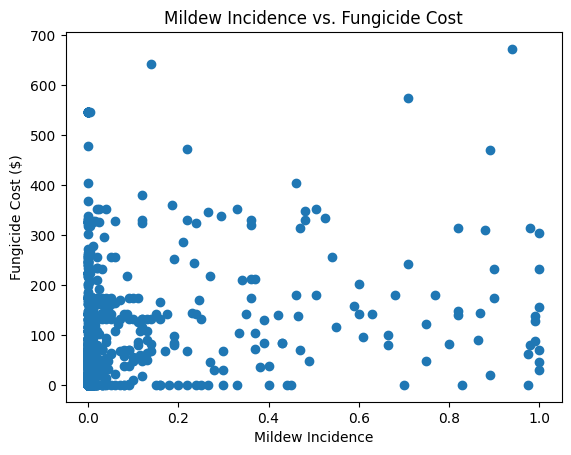

In [88]:
# Scatter plot showing relationship between mildew incidence and fungicide cost with axis labels
plt.scatter(cost_data['Mildew Incidence'], cost_data['Fungicide Cost'])
plt.xlabel('Mildew Incidence')
plt.ylabel('Fungicide Cost ($)')
plt.title('Mildew Incidence vs. Fungicide Cost')
plt.show()


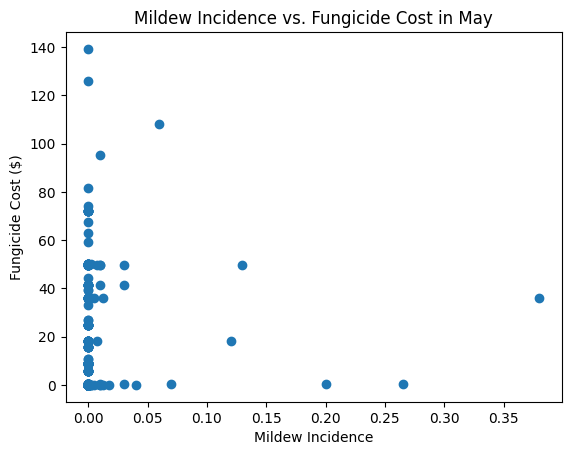

In [89]:
# Scatter plot showing relationship between mildew incidence and fungicide cost in month of May with axis labels
plt.scatter(cost_data['Mildew Incidence'].loc[cost_data['Month'] == 'May'], 
            cost_data['Fungicide Cost'].loc[cost_data['Month'] == 'May'])
plt.xlabel('Mildew Incidence')
plt.ylabel('Fungicide Cost ($)')
plt.title('Mildew Incidence vs. Fungicide Cost in May')
plt.show()


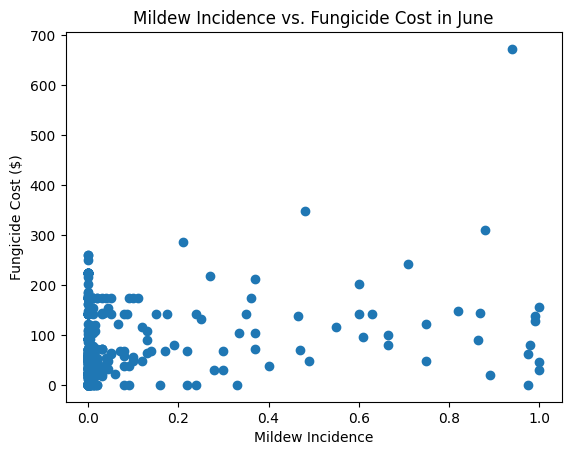

In [90]:
# Scatter plot showing relationship between mildew incidence and fungicide cost in month of June with axis labels
plt.scatter(cost_data['Mildew Incidence'].loc[cost_data['Month'] == 'June'], 
            cost_data['Fungicide Cost'].loc[cost_data['Month'] == 'June'])
plt.xlabel('Mildew Incidence')
plt.ylabel('Fungicide Cost ($)')
plt.title('Mildew Incidence vs. Fungicide Cost in June')
plt.show()

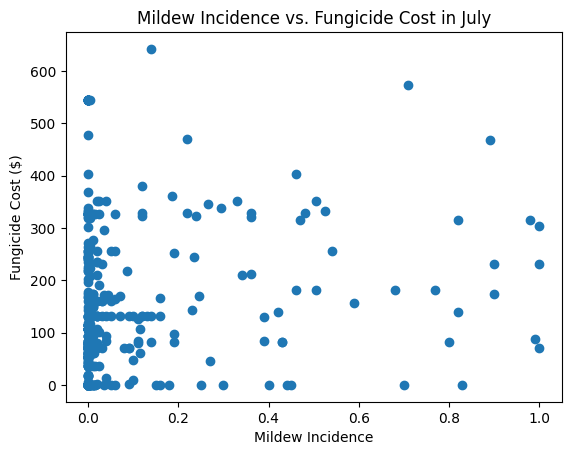

In [91]:
# Scatter plot showing relationship between mildew incidence and fungicide cost in month of July with axis labels
plt.scatter(cost_data['Mildew Incidence'].loc[cost_data['Month'] == 'July'], 
            cost_data['Fungicide Cost'].loc[cost_data['Month'] == 'July'])
plt.xlabel('Mildew Incidence')
plt.ylabel('Fungicide Cost ($)')
plt.title('Mildew Incidence vs. Fungicide Cost in July')
plt.show()

In [92]:
# Export pandas data to csv in directory ..\data\processed
cost_data.to_csv(r'..\data\processed\cost_data.csv', index=False)
early_cost_data.to_csv(r'..\data\processed\early_cost_data.csv', index=False)
late_cost_data.to_csv(r'..\data\processed\late_cost_data.csv', index=False)

# Intermediate Processing

## Year = 2014

In [93]:
import pandas as pd
import numpy as np
from quantulum3 import parser
import re
import matplotlib.pyplot as plt
from pyproj import Geod

# Import cost data
cost_data = pd.read_csv('../data/processed/cost_data.csv')

# Define year
yr = [2014, 2015, 2016, 2017]

for yr in yr:

    # Data for given year
    data = cost_data[cost_data['Year'] == yr]

    # Number of yards i (source)
    N = data['Field ID'].unique().shape[0]

    # Number of yards j (target)
    M = data['Field ID'].unique().shape[0]

    periods = [0, 1]

    # Create arrays containing the number of plants sampled in each yard
    n_apr = np.array(data.loc[data['Month'] == 'April', 'Hill'])
    n_may = np.array(data.loc[data['Month'] == 'May', 'Hill'])
    n_jun = np.array(data.loc[data['Month'] == 'June', 'Hill'])
    n_jul = np.array(data.loc[data['Month'] == 'July', 'Hill'])

    # Create arrays containing the number of diseased plants in each yard
    y_apr = np.array(data.loc[data['Month'] == 'April', 'w/PM'])
    y_may = np.array(data.loc[data['Month'] == 'May', 'w/PM'])
    y_jun = np.array(data.loc[data['Month'] == 'June', 'w/PM'])
    y_jul = np.array(data.loc[data['Month'] == 'July', 'w/PM'])

    # Create arrays containing the number of diseased plants in each OTHER yard
    z_may = np.array(data.loc[data['Month'] == 'May', 'w/PM'])
    z_jun = np.array(data.loc[data['Month'] == 'June', 'w/PM'])
    z_jul = np.array(data.loc[data['Month'] == 'July', 'w/PM'])

    # Create arrays containing the area (hectares) of each yard
    a_apr = np.array(data.loc[data['Month'] == 'April', 'Area_Hectares'])
    a_may = np.array(data.loc[data['Month'] == 'May', 'Area_Hectares'])
    a_jun = np.array(data.loc[data['Month'] == 'June', 'Area_Hectares'])
    a_jul = np.array(data.loc[data['Month'] == 'July', 'Area_Hectares'])

    # Create arrays containing the fungicide spray amount
    s_apr = np.array(data.loc[data['Month'] == 'April', 'Sprays'])
    s_may = np.array(data.loc[data['Month'] == 'May', 'Sprays'])
    s_jun = np.array(data.loc[data['Month'] == 'June', 'Sprays'])
    s_jul = np.array(data.loc[data['Month'] == 'July', 'Sprays'])

    # Create arrays for wind speed and percent time
    
    # Function to normalize the values so that they sum up to 1 for each row
    def normalize(array):
        row_sums = array.sum(axis=1, keepdims=True)
        return array / row_sums

    # April
    wind_percent_time_apr = np.array(data[data['Month'] == 'April'].filter(like='Percent')) / 100
    wind_percent_time_apr = normalize(wind_percent_time_apr)

    # May
    wind_percent_time_may = np.array(data[data['Month'] == 'May'].filter(like='Percent')) / 100
    wind_percent_time_may = normalize(wind_percent_time_may)

    # June
    wind_percent_time_jun = np.array(data[data['Month'] == 'June'].filter(like='Percent')) / 100
    wind_percent_time_jun = normalize(wind_percent_time_jun)

    # July
    wind_percent_time_jul = np.array(data[data['Month'] == 'July'].filter(like='Percent')) / 100
    wind_percent_time_jul = normalize(wind_percent_time_jul)

    # Select columns that start with 'Avg WS' for each month
    wind_speed_apr = np.array(data[data['Month'] == 'April'].filter(like='Avg WS'))
    wind_speed_may = np.array(data[data['Month'] == 'May'].filter(like='Avg WS'))
    wind_speed_jun = np.array(data[data['Month'] == 'June'].filter(like='Avg WS'))
    wind_speed_jul = np.array(data[data['Month'] == 'July'].filter(like='Avg WS'))
    

    # Compute wind run and convert from mi/hr to km/s
    wind_run_apr = wind_speed_apr * wind_percent_time_apr * 0.44704 * 0.001
    wind_run_may = wind_speed_may * wind_percent_time_may * 0.44704 * 0.001
    wind_run_jun = wind_speed_jun * wind_percent_time_jun * 0.44704 * 0.001
    wind_run_jul = wind_speed_jul * wind_percent_time_jul * 0.44704 * 0.001


    # INDICATOR FUNCTIONS

    # Create sI1 containing the indicator on whether target yard is affected by a V6-pathogen strain
    sI1_apr = np.array(data.loc[data['Month'] == 'April', 'Initial Strain'])
    sI1_may = np.array(data.loc[data['Month'] == 'May', 'Initial Strain'])
    sI1_jun = np.array(data.loc[data['Month'] == 'June', 'Initial Strain'])
    sI1_jul = np.array(data.loc[data['Month'] == 'July', 'Initial Strain'])

    # Create containing the constant array of 1's
    sI2 = np.ones((N,))

    # Create tI1 containing the indicator on whether target yard is only susceptible to V6-pathogen strain
    tI1 = np.zeros((N,))

    # Create tI2 containing the indicator on whether target yard is susceptible to both pathogen strains
    tI2 = np.zeros((N,))


    field_id = data['Field ID'].unique()

    for i in range(len(field_id)):

        sus_to_r6 = data.loc[(data['Month'] == 'May') & (data['Field ID'] == field_id[i]), 'Susceptibility to R6 Strains'].values[0]
        sus_to_nonr6 = data.loc[(data['Month'] == 'May') & (data['Field ID'] == field_id[i]), 'Susceptibility to non-R6 Strains'].values[0]
        
        # tI1
        
        if ((sus_to_r6 == 1) & (sus_to_nonr6 == 0)):  
            tI1[i] = 1
            
        else:
            tI1[i] = 0
        
        # tI2
            
        if ((sus_to_r6 == 1) & (sus_to_nonr6 == 1)):  
            tI2[i] = 1
        
        else:
            tI2[i] = 0
            
    # Function to convert bearing to angle in standard form
    def standard_form(angle):
        
        theta = np.pi / 2 - angle
        theta = np.where(theta < 0, theta + 2 * np.pi, theta)
        theta = np.where(theta > 2 * np.pi, theta - 2 * np.pi, theta)
        
        return theta

    # Function to convert convert angle to angle between 0 and 2pi
    def coterminal(angle):
        
        theta = np.where(angle < 0, angle + 2 * np.pi, angle)
        theta = np.where(theta > 2 * np.pi, theta - 2 * np.pi, theta)
        
        return theta

    # Cardinal direction labels
    cardinal_directions = np.array(['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'])

    # Define 16 cardinal angles in radians
    cardinal_angles = np.linspace(0, 2 * np.pi, 17)
    cardinal_angles = cardinal_angles[:-1]

    # Convert bearing to angles in standard form
    cardinal_angles = standard_form(cardinal_angles)

    # Define geodesic shape of earth
    wgs84_geod = Geod(ellps='WGS84')

    # Create bearing_tensor containing the geodesic bearing between the great circles
    bearing_tensor = np.zeros((N, M))
    
    # Unique fields   
    field_id = data['Field ID'].unique()

    # Create distance containing geodesic distance between yard k and yard l
    distance = np.zeros((N, M))
    
    for i in range(N):
        for j in range(N):
            
            lat_i = data.loc[data['Field ID'] == field_id[i], 'Centroid Lat'].values[0]
            long_i = data.loc[data['Field ID'] == field_id[i], 'Centroid Long'].values[0]
            
            lat_j = data.loc[data['Field ID'] == field_id[j], 'Centroid Lat'].values[0]
            long_j = data.loc[data['Field ID'] == field_id[j], 'Centroid Long'].values[0]

            az_ij, az_jk, dist = wgs84_geod.inv(long_i, lat_i, long_j, lat_j)
            
            # Compute distance in km between yards k and l
            distance[i][j] = dist * 0.001
            
            # Convert azimuth to standard form
            az_ij = standard_form(az_ij * np.pi / 180)
            
            # Compute geodesic bearing from yard k to yard l
            if i == j:
                bearing_tensor[i][j] = np.nan
            else:
                bearing_tensor[i][j] = az_ij
                
    # Create wind[i][j][k][l] containing mean of scalar projections of wind run
    # where i is the year, j is the month
    # k is the yard from which wind originates and l is the destination yard

    wind_apr = np.zeros((N, M))
    wind_may = np.zeros((N, M))
    wind_jun = np.zeros((N, M))
    wind_jul = np.zeros((N, M))
    

    for i in range(N):
        for j in range(M):

            # Define bounds within +/- 90 degrees of the bearing from yard i to yard j
            bounds = np.array([bearing_tensor[i][j] - np.pi / 2, bearing_tensor[i][j] + np.pi / 2])
            lower_bound = coterminal(min(bounds))
            upper_bound = coterminal(max(bounds))
            
            # Select cardinal directions within bounds
            cardinal_index = np.where(lower_bound < upper_bound, (lower_bound < cardinal_angles) & (cardinal_angles < upper_bound), (lower_bound < cardinal_angles) | (cardinal_angles < upper_bound))
            cardinal_index_num = np.where(cardinal_index)
            cardinal_index_num = cardinal_index_num[0]
            
            if len(cardinal_index_num) == 0:
                cardinal_index_num = [0] * 8
                
            # Compute bearing vector by first converting bearing to angles in standard position
            bearing_vector = np.array([np.cos(bearing_tensor[i][j]), np.sin(bearing_tensor[i][j])])
            
            # Select cardinal angles within bounds and convert to angles in standard position
            theta = cardinal_angles[cardinal_index]
            if len(theta) == 0:
                theta = [np.nan] * 8
            
            scalar_proj_list_apr = np.zeros((8, 1))
            scalar_proj_list_may = np.zeros((8, 1))
            scalar_proj_list_jun = np.zeros((8, 1))
            scalar_proj_list_jul = np.zeros((8, 1))
            
            for m in range(len(theta)):
                
                # APRIL
                
                # Compute wind vector
                wind_vector_apr = wind_run_apr[i][cardinal_index_num[m]] * np.array([np.cos(theta[m]), np.sin(theta[m])])
                wind_vector_apr = wind_vector_apr.T
                
                wind_vector_apr = wind_run_apr[i][cardinal_index_num[m]] * np.array([np.cos(theta[m]), np.sin(theta[m])])
                wind_vector_apr = wind_vector_apr.T
                
                wind_vector_apr = wind_run_apr[i][cardinal_index_num[m]] * np.array([np.cos(theta[m]), np.sin(theta[m])])
                wind_vector_apr = wind_vector_apr.T
            
                # Compute scalar projection of wind_vector onto bearing_vector
                scalar_proj_apr = np.dot(wind_vector_apr, bearing_vector) / np.linalg.norm(bearing_vector)
                scalar_proj_list_apr[m] = scalar_proj_apr
                
                # MAY
                
                # Compute wind vector
                wind_vector_may = wind_run_may[i][cardinal_index_num[m]] * np.array([np.cos(theta[m]), np.sin(theta[m])])
                wind_vector_may = wind_vector_may.T
                
                wind_vector_may = wind_run_may[i][cardinal_index_num[m]] * np.array([np.cos(theta[m]), np.sin(theta[m])])
                wind_vector_may = wind_vector_may.T
                
                wind_vector_may = wind_run_may[i][cardinal_index_num[m]] * np.array([np.cos(theta[m]), np.sin(theta[m])])
                wind_vector_may = wind_vector_may.T
            
                # Compute scalar projection of wind_vector onto bearing_vector
                scalar_proj_may = np.dot(wind_vector_may, bearing_vector) / np.linalg.norm(bearing_vector)
                scalar_proj_list_may[m] = scalar_proj_may
                
                # JUNE
                
                # Compute wind vector
                wind_vector_jun = wind_run_jun[i][cardinal_index_num[m]] * np.array([np.cos(theta[m]), np.sin(theta[m])])
                wind_vector_jun = wind_vector_jun.T
                
                wind_vector_jun = wind_run_jun[i][cardinal_index_num[m]] * np.array([np.cos(theta[m]), np.sin(theta[m])])
                wind_vector_jun = wind_vector_jun.T
                
                wind_vector_jun = wind_run_jun[i][cardinal_index_num[m]] * np.array([np.cos(theta[m]), np.sin(theta[m])])
                wind_vector_jun = wind_vector_jun.T
            
                # Compute scalar projection of wind_vector onto bearing_vector
                scalar_proj_jun = np.dot(wind_vector_jun, bearing_vector) / np.linalg.norm(bearing_vector)
                scalar_proj_list_jun[m] = scalar_proj_jun
                
                # JULY
                
                # Compute wind vector
                wind_vector_jul = wind_run_jul[i][cardinal_index_num[m]] * np.array([np.cos(theta[m]), np.sin(theta[m])])
                wind_vector_jul = wind_vector_jun.T
                
                wind_vector_jul = wind_run_jul[i][cardinal_index_num[m]] * np.array([np.cos(theta[m]), np.sin(theta[m])])
                wind_vector_jul = wind_vector_jul.T
                
                wind_vector_jul = wind_run_jul[i][cardinal_index_num[m]] * np.array([np.cos(theta[m]), np.sin(theta[m])])
                wind_vector_jul = wind_vector_jul.T
            
                # Compute scalar projection of wind_vector onto bearing_vector
                scalar_proj_jul = np.dot(wind_vector_jul, bearing_vector) / np.linalg.norm(bearing_vector)
                scalar_proj_list_jul[m] = scalar_proj_jul
            
            
            # Compute mean of scalar projections    
            if i == j:
                wind_apr[i][j] = 0.0
                wind_may[i][j] = 0.0
                wind_jun[i][j] = 0.0
                wind_jul[i][j] = 0.0
            else:
                wind_apr[i][j] = np.sum(scalar_proj_list_apr) / len(scalar_proj_list_apr)
                wind_may[i][j] = np.sum(scalar_proj_list_may) / len(scalar_proj_list_may)
                wind_jun[i][j] = np.sum(scalar_proj_list_jun) / len(scalar_proj_list_jun)
                wind_jul[i][j] = np.sum(scalar_proj_list_jul) / len(scalar_proj_list_jul)
                
     
    # Save data 
                
    if yr == 2014:
        np.savez('../data/processed/data_2014', N=N, M=M, distance=distance, sI2=sI2, tI1=tI1, tI2=tI2, 
        y_apr=y_apr, n_apr=n_apr, a_apr=a_apr, wind_apr=wind_apr, sI1_apr=sI1_apr, s_apr=s_apr,
        y_may=y_may, n_may=n_may, a_may=a_may, wind_may=wind_may, sI1_may=sI1_may, s_may=s_may, 
        y_jun=y_jun, n_jun=n_jun, a_jun=a_jun, wind_jun=wind_jun, sI1_jun=sI1_jun, s_jun=s_jun,
        y_jul=y_jul, n_jul=n_jul, a_jul=a_jul, wind_jul=wind_jul, sI1_jul=sI1_jul, s_jul=s_jul)
        
    elif yr == 2015:
        np.savez('../data/processed/data_2015', N=N, M=M, distance=distance, sI2=sI2, tI1=tI1, tI2=tI2, 
        y_apr=y_apr, n_apr=n_apr, a_apr=a_apr, wind_apr=wind_apr, sI1_apr=sI1_apr, s_apr=s_apr,
        y_may=y_may, n_may=n_may, a_may=a_may, wind_may=wind_may, sI1_may=sI1_may, s_may=s_may, 
        y_jun=y_jun, n_jun=n_jun, a_jun=a_jun, wind_jun=wind_jun, sI1_jun=sI1_jun, s_jun=s_jun,
        y_jul=y_jul, n_jul=n_jul, a_jul=a_jul, wind_jul=wind_jul, sI1_jul=sI1_jul, s_jul=s_jul)

    elif yr == 2016:
        np.savez('../data/processed/data_2016', N=N, M=M, distance=distance, sI2=sI2, tI1=tI1, tI2=tI2, 
        y_apr=y_apr, n_apr=n_apr, a_apr=a_apr, wind_apr=wind_apr, sI1_apr=sI1_apr, s_apr=s_apr,
        y_may=y_may, n_may=n_may, a_may=a_may, wind_may=wind_may, sI1_may=sI1_may, s_may=s_may, 
        y_jun=y_jun, n_jun=n_jun, a_jun=a_jun, wind_jun=wind_jun, sI1_jun=sI1_jun, s_jun=s_jun,
        y_jul=y_jul, n_jul=n_jul, a_jul=a_jul, wind_jul=wind_jul, sI1_jul=sI1_jul, s_jul=s_jul)

    elif yr == 2017:
        np.savez('../data/processed/data_2017', N=N, M=M, distance=distance, sI2=sI2, tI1=tI1, tI2=tI2, 
        y_apr=y_apr, n_apr=n_apr, a_apr=a_apr, wind_apr=wind_apr, sI1_apr=sI1_apr, s_apr=s_apr,
        y_may=y_may, n_may=n_may, a_may=a_may, wind_may=wind_may, sI1_may=sI1_may, s_may=s_may, 
        y_jun=y_jun, n_jun=n_jun, a_jun=a_jun, wind_jun=wind_jun, sI1_jun=sI1_jun, s_jun=s_jun,
        y_jul=y_jul, n_jul=n_jul, a_jul=a_jul, wind_jul=wind_jul, sI1_jul=sI1_jul, s_jul=s_jul)